# Gradient Descent and Newton's Method in TensorFlow
In this exercise, we will compare gradient descent and Newton's method for finding a local minima/saddle point of a function. We must compute the [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) for Newton's method. In general, this is space complexity $\mathcal{O}(n^2)$ so we do not calculate it in practice, however since we will only be dealing with functions of two variables, we will do it here to demonstrate Newton's method. In the real world, we would use a quasi-Newton method that approximates the Hessian using information from the gradient such as [BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).

We will look at the functions:
- $z=3x^2-5xy^3$
- $z=\sin x^2 + \cos y^2$

In [ ]:
# Necessary imports
import numpy as np
import tensorflow as tf

# So we can plot in 3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

## Gradient Descent
The iteration equation for gradient descent is,

$$x_{n+1}=x_n-\eta\nabla f(x_n)$$

where $\eta$ is our learning rate and $f$ is the function we want to minimize. We will use a `tf.GradientTape` to compute $\nabla f(x_n)$.

In [ ]:
# Using the `tf.function` decorator will greatly speed up our iterations via 
# AutoGraph
@tf.function
def gradient_descent(f, x, y):
    with tf.GradientTape() as g:
        # Evaluate f'
        z = f(x, y)
    # Derivative of f w.r.t. x and y
    grads = g.gradient(z, [x, y])
    # Learning rate
    eta = 0.01
    # `x.assign_sub(n)` is equivalent to x -= n for `tf.Variable`s
    x.assign_sub(eta * grads[0])
    y.assign_sub(eta * grads[1])
    
    # Return so we can keep track of our iteration values
    return x, y

## Newton's Method
THe iteration equation for Newton's method is,

$$x_{n+1}=x_n-\eta H_f^{-1}(x_n)\nabla f(x_n)$$

We must compute an inverse Hessian matrix $H_f^{-1}(x_n)$. The Hessian matrix aggregates all the second derivatives of a vector-valued function, in this case the gradient $\nabla f(x_n)$. For variables $x,y$, the Hessian takes the form,

$$H_f=\begin{pmatrix}
\frac{\partial^2{f}}{\partial{x}^2} & \frac{\partial^2{f}}{\partial{x}\partial{y}} \\ \frac{\partial^2{f}}{\partial{y}\partial{x}} & \frac{\partial^2{f}}{\partial{y}^2}
\end{pmatrix}$$

It almost never justified in the computational sense to compute a matrix inverse (`tf.linalg.inv`) due to its large space complexity, so instead we will solve the linear system (`tf.linalg.solve`) $H_f(x_n)v=\nabla f(x_n)$ for $v$ which implicitly computes the inverse. It utilizes [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition) to solve the system.


In [ ]:
@tf.function
def newton(f, x, y):
    # Nested `tf.GradientTape`s to computer second-order derivatives
    # They must be persistent since we call `tf.GradientTape.gradient` multiple
    # times
    with tf.GradientTape(persistent=True) as g:
        with tf.GradientTape(persistent=True) as gg:
            z = f(x, y)
        # Get first-order derivatives
        dz_dx = gg.gradient(z, x)
        dz_dy = gg.gradient(z, y)
    # Replace any `None` gradients with zero. Processing gradients is something 
    # you'll need to do when using advanced automatic differentiation
    process_gradient = lambda d: [0 if i is None else i for i in d]
    # Get second-order derivatives
    d2z_dx2 = process_gradient(g.gradient(dz_dx, [x, y]))
    d2z_dy2 = process_gradient(g.gradient(dz_dy, [x, y]))

    # For memory efficiency, we can allow our `tf.GradientTape`s to be 
    # garbage-collected here
    del g, gg

    # Stack `d2z_dx2` and `d2z_dy2` vertically to get the Hessian matrix
    hessian = tf.stack((d2z_dx2, d2z_dy2))
    
    # NOTE: DO NOT DO THIS. It computes the inverse Hessian explicitly
    # update = tf.matmul(tf.linalg.inv(hessian), [[dz_dx], [dz_dy]])
    
    # We will create a small epsilon value to add to our Hessian in case of 
    # zero derivatives
    epsilon = 1e-3 * tf.eye(hessian.shape[0])
    # Solve to get H^-1 * f'
    update = tf.linalg.solve(hessian + epsilon, [[dz_dx], [dz_dy]])

    # Update `x` and `y`
    eta = 0.05
    x.assign_sub(eta * tf.squeeze(update[0]))
    y.assign_sub(eta * tf.squeeze(update[1]))

    return x, y

## Minimizing $z=3x^2-5xy^3$
Let's plot the function first.

In [ ]:
f1 = lambda x, y: 3 * x ** 2 - 5 * x * y ** 3

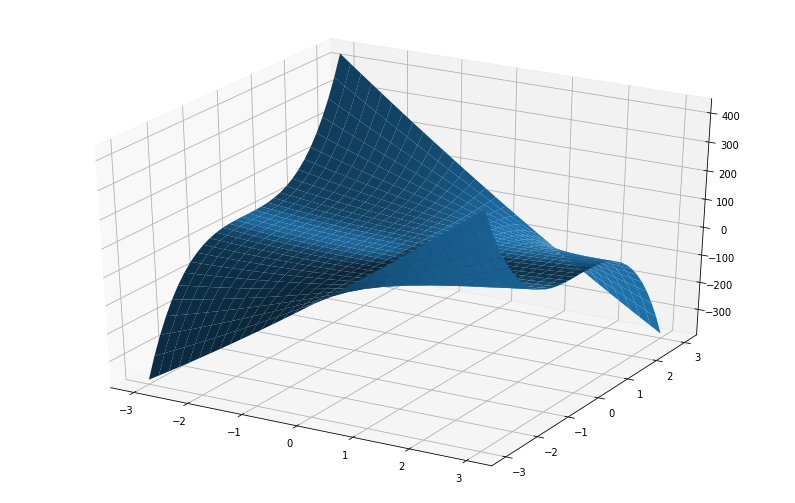

In [ ]:
# Create a 32x32 grid to plot function
X = np.outer(np.linspace(-3, 3, 32), np.ones(32)) # u, v -> uv^T
Y = X.copy().T

Z = f1(X, Y)

fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

Let's create `tf.Variable`s for $x$ and $y$ with an initial guess of 1 for each.

In [ ]:
# TensorFlow is strictly typed so we must specify these are floats
x = tf.Variable(1, dtype=tf.float32)
y = tf.Variable(1, dtype=tf.float32)

In [ ]:
lst1x = []
lst1y = []
# 1000 iterations of gradient descent
for _ in range(1000):
    one, two = gradient_descent(f1, x, y)
    lst1x.append(one)
    lst1y.append(two)
lst1x = np.array([i.numpy() for i in lst1x])
lst1y = np.array([i.numpy() for i in lst1y])

We can see that gradient descent does not converge to the saddle point of this function.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in power
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


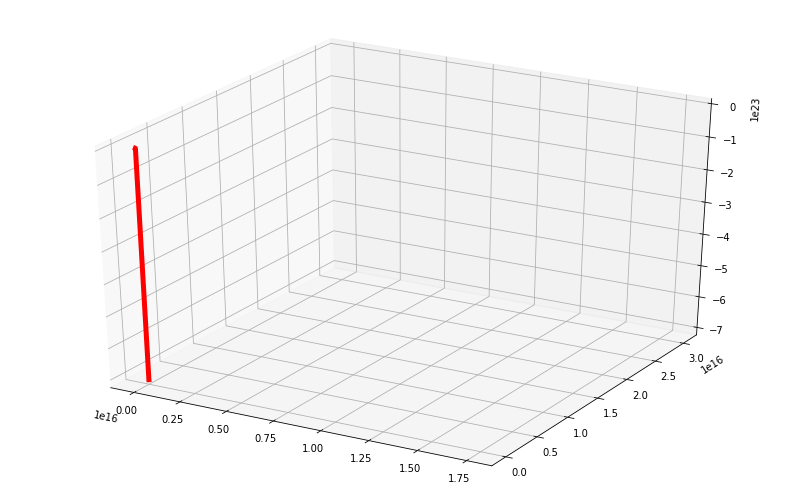

In [ ]:
X = np.outer(np.linspace(-3, 3, 32), np.ones(32)) # u, v -> uv^T
Y = X.copy().T

Z = f1(X, Y)

fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
# Add an alpha to make transluscent 
ax.plot_surface(X, Y, Z, alpha=0.2)
ax.plot(lst1x, lst1y, f1(lst1x, lst1y), 'r', linewidth=5)
plt.show()

Now let's try using Newton's Method.

In [ ]:
x = tf.Variable(1, dtype=tf.float32)
y = tf.Variable(1, dtype=tf.float32)

In [ ]:
lst2x = []
lst2y = []
for _ in range(1000):
    one, two = newton(f1, x, y)
    lst2x.append(one)
    lst2y.append(two)
lst2x = np.array([i.numpy() for i in lst2x])
lst2y = np.array([i.numpy() for i in lst2y])

We can see that Newton's method easily converges to the saddle point of this function with the additional curvature information provided by the Hessian.

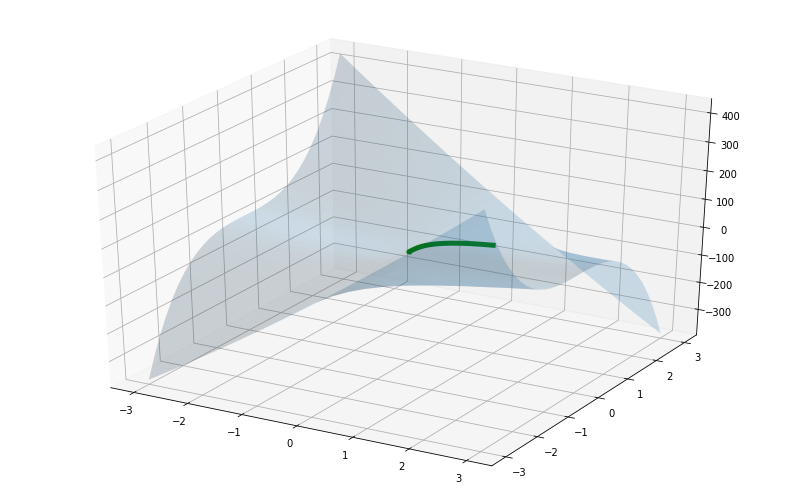

In [ ]:
X = np.outer(np.linspace(-3, 3, 32), np.ones(32))
Y = X.copy().T

Z = f1(X, Y)

fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.2)
ax.plot(lst2x, lst2y, f1(lst2x, lst2y), 'g', linewidth=5)
plt.show()

## Minimizing $z=\sin x^2 + \cos y^2$
Again, let's plot the function.

In [ ]:
f2 = lambda x, y: tf.sin(x ** 2) + tf.cos(y ** 2)

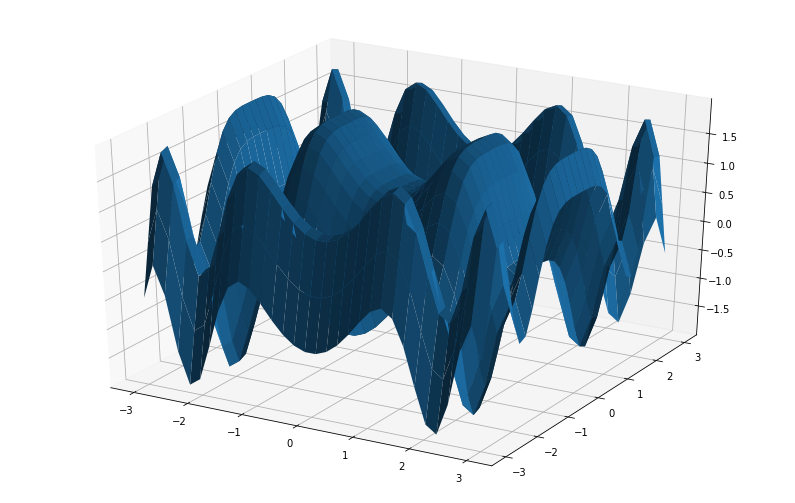

In [ ]:
X = np.outer(np.linspace(-3, 3, 32), np.ones(32)) # u, v -> uv^T
Y = X.copy().T

Z = f2(X, Y)

fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

Now it's time to compare gradient descent and Newton's method.

In [ ]:
x = tf.Variable(1, dtype=tf.float32)
y = tf.Variable(1, dtype=tf.float32)
lst1x = []
lst1y = []
for _ in range(1000):
    one, two = gradient_descent(f2, x, y)
    lst1x.append(one)
    lst1y.append(two)
lst1x = np.array([i.numpy() for i in lst1x])
lst1y = np.array([i.numpy() for i in lst1y])

In [ ]:
x = tf.Variable(1, dtype=tf.float32)
y = tf.Variable(1, dtype=tf.float32)
lst2x = []
lst2y = []
for _ in range(1000):
    one, two = newton(f2, x, y)
    lst2x.append(one)
    lst2y.append(two)
lst2x = np.array([i.numpy() for i in lst2x])
lst2y = np.array([i.numpy() for i in lst2y])

We can see that both methods behave differently. Gradient descent appears to do a better job and this could be due to the curvature information pushing Newton's method in another direction. It is important to remember these methods are only guaranteed to find local minima/saddle points. This should give you an intuition about how difficult it is to optimize functions of many variables. Due to the extra computational complexity of higher-order methods like Newton's, we generally stick to gradient descent with some creative modifications (like Adam which we'll cover in later labs) that tend to work well on these multivariate functions.

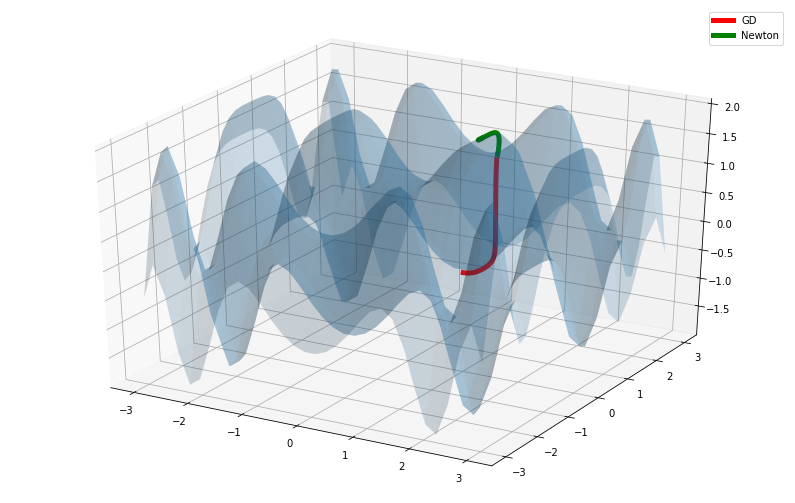

In [ ]:
X = np.outer(np.linspace(-3, 3, 32), np.ones(32)) # u, v -> uv^T
Y = X.copy().T

Z = f2(X, Y)

fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, alpha=0.2)
ax.plot(lst1x, lst1y, np.sin(lst1x ** 2) + np.cos(lst1y ** 2), 'r', linewidth=5,
        label='GD')
ax.plot(lst2x, lst2y, np.sin(lst2x ** 2) + np.cos(lst2y ** 2), 'g', linewidth=5, 
        label='Newton')
ax.legend()
plt.show()